In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from tqdm import trange
from itertools import combinations
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Reshape, Lambda, Input, LeakyReLU
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

In [3]:
img_dim=512

In [6]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator = train_datagen.flow_from_directory(
    directory=r"/content/drive/MyDrive/Airbnb Data/Training Data",
    color_mode="rgb",
    batch_size=1,
    target_size=(img_dim, img_dim),
    class_mode="sparse",
    shuffle=False,
    seed=42
)

Found 631 images belonging to 12 classes.


In [7]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(
    directory=r"/content/drive/MyDrive/Airbnb Data/Test Data",
    color_mode="rgb",
    batch_size=1,
    target_size=(img_dim, img_dim),
    class_mode="sparse",
    shuffle=False,
    seed=42
)

Found 233 images belonging to 5 classes.


In [8]:

def random_crop(img, random_crop_size=(img_dim, img_dim)):
    # Note: image_data_format is 'channel_last'
    assert img.shape[2] == 3
    height, width = img.shape[0], img.shape[1]
    dy, dx = random_crop_size
    x = np.random.randint(0, width - dx + 1)
    y = np.random.randint(0, height - dy + 1)
    return img[y:(y+dy), x:(x+dx), :]

def crop(batch):
    batch_crops = np.zeros((batch.shape[0], img_dim, img_dim, 3))
    for i in range(batch.shape[0]):
        batch_crops[i] = random_crop(batch[i])
    return batch_crops

def crop_generator(batches):
    """Take as input a Keras ImageGen (Iterator) and generate random
    crops from the image batches generated by the original iterator.
    """
    while True:
        tup = next(batches)
        yield (crop(tup[0]), crop(tup[1]), *tup[2:])

In [9]:
# id_dict = (id, cls) -> [positive examples]
# class_dict = (id) -> {cls}

def get_dicts(image_generator):
  id_dict = {}
  class_dict = {}
  for idx in trange(len(image_generator)):
    img, cls = image_generator.next()
    img_name = image_generator.filenames[idx]
    img = img[0]
    cls = int(cls[0])
    id = img_name.split('_')[1]
    if id in class_dict:
      class_dict[id].add(cls)
    else:
      class_dict[id] = {cls}
    if (id, cls) in id_dict:
      id_dict[(id, cls)].append(img)
    else:
      id_dict[(id, cls)] = [img]
  return id_dict, class_dict

In [10]:
train_id_dict, train_class_dict = get_dicts(train_generator)
test_id_dict, test_class_dict = get_dicts(test_generator)

100%|██████████| 233/233 [01:43<00:00,  2.25it/s]


In [11]:
!nvidia-smi

Tue Nov  7 07:42:31 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [12]:
# returns a tuple of (batch_a, batch_b, epoch_end)
#                    (Tensor, Tensor, bool) where bool indicates end of epoch

def get_pos_batch(class_dict, id_dict, batch_size = 32):
  batch_a =  np.zeros((batch_size, img_dim, img_dim, 3)) # (16, 256, 256, 3)
  batch_b =  np.zeros((batch_size, img_dim, img_dim, 3)) # (16, 256, 256, 3)
  batch_idx = 0
  class_keys = list(class_dict.keys())
  np.random.shuffle(class_keys)
  for id in class_keys:
    classes = class_dict[id]
    for cls in classes:
      pos_examples = id_dict[(id,cls)] # list of positive examples
      for a, b in combinations(pos_examples, 2):
        batch_a[batch_idx, :, :, :] = a
        batch_b[batch_idx, :, :, :] = b
        batch_idx += 1
        if batch_idx == batch_size:
          yield [batch_a[:batch_idx], batch_b[:batch_idx], False]
          batch_a =  np.zeros((batch_size, img_dim, img_dim, 3))
          batch_b =  np.zeros((batch_size, img_dim, img_dim, 3))
          batch_idx = 0
  yield [batch_a[:batch_idx], batch_b[:batch_idx], True]

In [13]:
def get_neg_batch(class_dict, id_dict, batch_size = 32):
  batch_a =  np.zeros((batch_size, img_dim, img_dim, 3)) # (16, 256, 256, 3)
  batch_b =  np.zeros((batch_size, img_dim, img_dim, 3)) # (16, 256, 256, 3)
  batch_idx = 0
  ids = list(class_dict.keys())

  while True:
    random_ids = np.random.choice(ids, 2)
    classes_for_id_one = list(class_dict[random_ids[0]])
    random_class_from_one = np.random.choice(classes_for_id_one ,1)[0]
    classes_for_id_two = list(class_dict[random_ids[1]])
    random_class_from_two = np.random.choice(classes_for_id_two ,1)[0]

    if random_class_from_two != random_class_from_one:
      a, b = id_dict[(random_ids[0],random_class_from_one)], id_dict[(random_ids[1],random_class_from_two)]
      batch_a[batch_idx, :, :, :] = a[np.random.choice(len(a))]
      batch_b[batch_idx, :, :, :] = b[np.random.choice(len(b))]
      batch_idx += 1
      if batch_idx == batch_size:
        yield [batch_a[:batch_idx], batch_b[:batch_idx]]
        batch_a =  np.zeros((batch_size, img_dim, img_dim, 3))
        batch_b =  np.zeros((batch_size, img_dim, img_dim, 3))
        batch_idx = 0

In [14]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def contrastive_loss(y_true, y_pred):
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

In [15]:
optimizer = Adam()
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_dim, img_dim, 3))
base_model.trainable=False
model = Sequential([
       base_model,
       Conv2D(filters=1, kernel_size=(1,1)),
       Reshape((256,)),
       Dense(32, activation=LeakyReLU(0.1)),
       Dense(16)
])

model.summary()

94765736/94765736 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 16, 16, 2048)      23587712  
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 1)         2049      
                                                                 
 reshape (Reshape)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 32)                8224      
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
Total params: 23598513 (90.02 MB)
Trainable params: 10801 (42.19 KB)
Non-trainable params: 23587712 (89.98 MB)
____________

In [16]:
inp_a = Input(shape=(img_dim, img_dim, 3), name='a')
inp_b = Input(shape=(img_dim, img_dim, 3), name='b')
out_a, out_b = model(inp_a), model(inp_b)
distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape) ([out_a, out_b])

final_model = Model([inp_a, inp_b], distance)
final_model.compile(optimizer=optimizer, loss=contrastive_loss)
final_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 a (InputLayer)              [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 b (InputLayer)              [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 16)                   2359851   ['a[0][0]',                   
                                                          3          'b[0][0]']                   
                                                                                                  
 lambda (Lambda)             (None, 1)                    0         ['sequential[0][0]',      

In [17]:
epochs, k = 20, 5

In [18]:
pos_loss = []
neg_loss = []
for epoch in trange(epochs):
  pos_gen = crop_generator(get_pos_batch(train_class_dict, train_id_dict, 32))
  neg_gen = crop_generator(get_neg_batch(train_class_dict, train_id_dict, 32))
  # 1 epoch
  p_loss, p_batches = 0, 0
  n_loss, n_batches = 0, 0
  while True:
    # positive examples
    batch_a, batch_b, epoch_end = next(pos_gen)
    pos_y = np.ones((batch_a.shape[0], 1))
    loss = final_model.train_on_batch({'a' : batch_a, 'b' : batch_b}, pos_y)
    p_loss += loss
    p_batches += 1

    # negative examples
    for _ in range(k):
      batch_a, batch_b = next(neg_gen)
      neg_y = np.zeros((batch_a.shape[0], 1))
      loss = final_model.train_on_batch({'a' : batch_a, 'b' : batch_b}, neg_y)
      n_loss += loss
      n_batches += 1

    if epoch_end:
      p_loss = p_loss / p_batches
      n_loss = n_loss / n_batches
      break
  # 1 epoch
  print(f'Epoch: {epoch+1}, time: {datetime.now().strftime("%H:%M:%S")}')
  print(f'avg (+) contrastive loss: {p_loss}')
  print(f'avg (-) contrastive loss: {n_loss}')
  pos_loss.append(p_loss)
  neg_loss.append(n_loss)

  5%|▌         | 1/20 [03:40<1:09:46, 220.35s/it]

Epoch: 1, time: 07:47:07
avg (+) contrastive loss: 36.99268163045247
avg (-) contrastive loss: 0.0010068300831092831


 10%|█         | 2/20 [06:49<1:00:33, 201.88s/it]

Epoch: 2, time: 07:50:16
avg (+) contrastive loss: 1.1881811340649924
avg (-) contrastive loss: 0.015962015837430954


 15%|█▌        | 3/20 [09:59<55:43, 196.69s/it]  

Epoch: 3, time: 07:53:26
avg (+) contrastive loss: 0.8721405903498332
avg (-) contrastive loss: 0.022534049140910308


 20%|██        | 4/20 [13:09<51:40, 193.76s/it]

Epoch: 4, time: 07:56:36
avg (+) contrastive loss: 0.7564198851585389
avg (-) contrastive loss: 0.02617409621675809


 25%|██▌       | 5/20 [16:18<48:05, 192.35s/it]

Epoch: 5, time: 07:59:46
avg (+) contrastive loss: 0.6838671326637268
avg (-) contrastive loss: 0.031365963084002337


 30%|███       | 6/20 [19:30<44:49, 192.13s/it]

Epoch: 6, time: 08:02:57
avg (+) contrastive loss: 0.6467511296272278
avg (-) contrastive loss: 0.033890571060280004


 35%|███▌      | 7/20 [22:41<41:30, 191.56s/it]

Epoch: 7, time: 08:06:08
avg (+) contrastive loss: 0.6050290107727051
avg (-) contrastive loss: 0.03261788380642732


 40%|████      | 8/20 [25:53<38:22, 191.90s/it]

Epoch: 8, time: 08:09:20
avg (+) contrastive loss: 0.5889911492665608
avg (-) contrastive loss: 0.033921916857361796


 45%|████▌     | 9/20 [29:05<35:10, 191.88s/it]

Epoch: 9, time: 08:12:32
avg (+) contrastive loss: 0.5665983517964681
avg (-) contrastive loss: 0.03350758619606495


 50%|█████     | 10/20 [32:15<31:53, 191.38s/it]

Epoch: 10, time: 08:15:42
avg (+) contrastive loss: 0.550760946671168
avg (-) contrastive loss: 0.03275285754352808


 55%|█████▌    | 11/20 [35:24<28:35, 190.59s/it]

Epoch: 11, time: 08:18:51
avg (+) contrastive loss: 0.5353130380312602
avg (-) contrastive loss: 0.03325237757215897


 60%|██████    | 12/20 [38:35<25:25, 190.71s/it]

Epoch: 12, time: 08:22:02
avg (+) contrastive loss: 0.506321781873703
avg (-) contrastive loss: 0.03402605305115382


 65%|██████▌   | 13/20 [41:48<22:18, 191.26s/it]

Epoch: 13, time: 08:25:15
avg (+) contrastive loss: 0.49772475361824037
avg (-) contrastive loss: 0.03153736480822166


 70%|███████   | 14/20 [44:59<19:07, 191.21s/it]

Epoch: 14, time: 08:28:26
avg (+) contrastive loss: 0.4890841563542684
avg (-) contrastive loss: 0.027998057082295417


 75%|███████▌  | 15/20 [48:12<15:59, 191.90s/it]

Epoch: 15, time: 08:31:39
avg (+) contrastive loss: 0.4687192221482595
avg (-) contrastive loss: 0.02888670744995276


 80%|████████  | 16/20 [51:28<12:52, 193.06s/it]

Epoch: 16, time: 08:34:55
avg (+) contrastive loss: 0.45467389027277627
avg (-) contrastive loss: 0.028629411285122235


 85%|████████▌ | 17/20 [54:38<09:36, 192.24s/it]

Epoch: 17, time: 08:38:05
avg (+) contrastive loss: 0.4426112552483877
avg (-) contrastive loss: 0.028155874498188495


 90%|█████████ | 18/20 [57:47<06:22, 191.33s/it]

Epoch: 18, time: 08:41:15
avg (+) contrastive loss: 0.42918026248613994
avg (-) contrastive loss: 0.027325972492496173


 95%|█████████▌| 19/20 [1:01:02<03:12, 192.19s/it]

Epoch: 19, time: 08:44:29
avg (+) contrastive loss: 0.4201608737309774
avg (-) contrastive loss: 0.026656780367096265


100%|██████████| 20/20 [1:04:11<00:00, 192.58s/it]

Epoch: 20, time: 08:47:38
avg (+) contrastive loss: 0.4045784056186676
avg (-) contrastive loss: 0.02468191130707661


In [19]:
# Get some positive examples and negative examples (TRAIN)
pos_gen = crop_generator(get_pos_batch(train_class_dict, train_id_dict))
neg_gen = crop_generator(get_neg_batch(train_class_dict, train_id_dict))

X_distance= []
y_distance = []

pos_batch_count = 0
neg_to_pos_ratio = 1

while True:
  batch_a, batch_b, epoch_end = next(pos_gen)
  for x in final_model.predict([batch_a, batch_b]):
    X_distance.append(x)
  y_distance += [1] * len(batch_a)
  pos_batch_count += 1
  if epoch_end:
    break

for _ in range(pos_batch_count * neg_to_pos_ratio):
  batch_a, batch_b = next(neg_gen)
  for x in final_model.predict([batch_a, batch_b]):
    X_distance.append(x)
  y_distance += [0] * len(batch_a)

X_distance, y_distance = np.array(X_distance).reshape((-1,)), np.array(y_distance)
X_distance = X_distance.reshape((-1, 1))

print(X_distance.shape, y_distance.shape)

1/1 [==============================] - 0s 226ms/step
(944, 1) (944,)


In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

clf = LogisticRegression(random_state=0, solver='lbfgs').fit(X_distance, y_distance)

print('Training F1 Score:', f1_score(y_distance, clf.predict(X_distance)))

Training F1 Score: 0.8513800424628449


[36.99268163045247, 1.1881811340649924, 0.8721405903498332, 0.7564198851585389, 0.6838671326637268, 0.6467511296272278, 0.6050290107727051, 0.5889911492665608, 0.5665983517964681, 0.550760946671168, 0.5353130380312602, 0.506321781873703, 0.49772475361824037, 0.4890841563542684, 0.4687192221482595, 0.45467389027277627, 0.4426112552483877, 0.42918026248613994, 0.4201608737309774, 0.4045784056186676]


<function matplotlib.pyplot.show(close=None, block=None)>

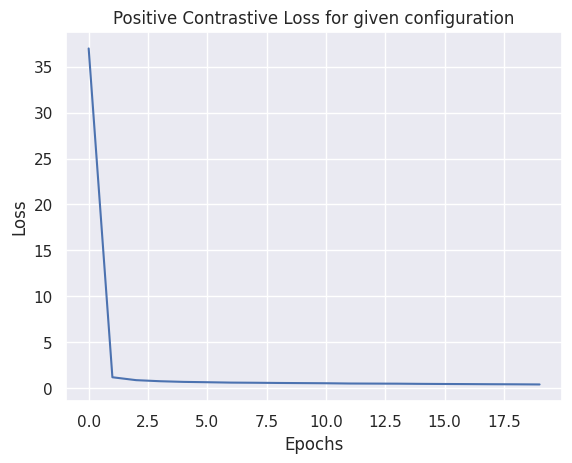

In [21]:
print(pos_loss)
plt.plot(np.arange(epochs), pos_loss)
plt.title('Positive Contrastive Loss for given configuration')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show

[0.0010068300831092831, 0.015962015837430954, 0.022534049140910308, 0.02617409621675809, 0.031365963084002337, 0.033890571060280004, 0.03261788380642732, 0.033921916857361796, 0.03350758619606495, 0.03275285754352808, 0.03325237757215897, 0.03402605305115382, 0.03153736480822166, 0.027998057082295417, 0.02888670744995276, 0.028629411285122235, 0.028155874498188495, 0.027325972492496173, 0.026656780367096265, 0.02468191130707661]


<function matplotlib.pyplot.show(close=None, block=None)>

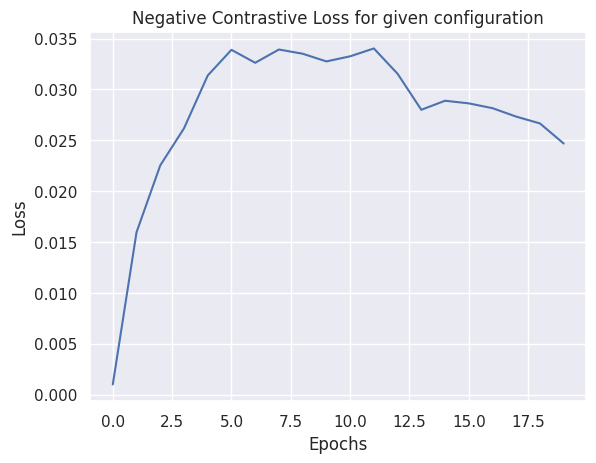

In [22]:
print(neg_loss)
plt.plot(np.arange(epochs), neg_loss)
plt.title('Negative Contrastive Loss for given configuration')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show

In [23]:
# Get some positive examples and negative examples (TRAIN)
pos_gen = crop_generator(get_pos_batch(test_class_dict, test_id_dict))
neg_gen = crop_generator(get_neg_batch(test_class_dict, test_id_dict))

X_distance= []
y_distance = []

pos_batch_count = 0
neg_to_pos_ratio = 1

while True:
  batch_a, batch_b, epoch_end = next(pos_gen)
  for x in final_model.predict([batch_a, batch_b]):
    X_distance.append(x)
  y_distance += [1] * len(batch_a)
  pos_batch_count += 1
  if epoch_end:
    break

for _ in range(pos_batch_count * neg_to_pos_ratio):
  batch_a, batch_b = next(neg_gen)
  for x in final_model.predict([batch_a, batch_b]):
    X_distance.append(x)
  y_distance += [0] * len(batch_a)

X_distance, y_distance = np.array(X_distance).reshape((-1,)), np.array(y_distance)
X_distance = X_distance.reshape((-1, 1))

print(X_distance.shape, y_distance.shape)

1/1 [==============================] - 0s 147ms/step
(294, 1) (294,)


In [24]:
print('Testing F1 Score:', f1_score(y_distance, clf.predict(X_distance)))

Testing F1 Score: 0.48803827751196166


In [26]:
from tensorflow.keras.models import load_model
final_model.save('final_model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [32]:
from tensorflow.keras.preprocessing import image
import numpy as np

img_path_1 = '/content/2.jpg'
img_path_2 = '/content/3.jpg'

img_1 = image.load_img(img_path_1, target_size=(img_dim, img_dim))
img_1 = image.img_to_array(img_1)
img_1 = np.expand_dims(img_1, axis=0)
img_1 = img_1 / 255.0  # Normalize the image data

img_2 = image.load_img(img_path_2, target_size=(img_dim, img_dim))
img_2 = image.img_to_array(img_2)
img_2 = np.expand_dims(img_2, axis=0)
img_2 = img_2 / 255.0  # Normalize the image data

# Use the Siamese network to compute similarity
similarity = final_model.predict([img_1, img_2])

print("Similarity score:", similarity)


1/1 [==============================] - 0s 59ms/step
Similarity score: [[0.18925671]]
